In [1]:
import numpy as np, agama
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import astropy.units as u
import os

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

[60.         60.         60.         ... 30.19445227 30.1725872
 30.15075377]


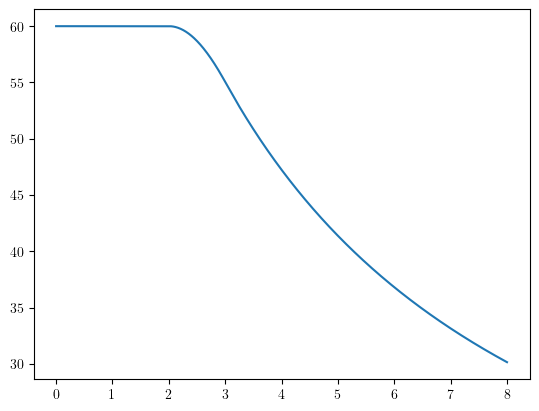

In [3]:
'''Create barred potential'''

# Function to calculate relative bar strength
def calc_bar_frac(t, t0, t1):
    xi = 2*(t - t0)/(t1 - t0) - 1
    bar_frac = np.clip(3/16*xi**5 - 5/8*xi**3 + 15/16*xi + 1/2, 0, 1)

    return bar_frac

from scipy.integrate import quad

def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Potential parameters
R_sun = 8.178
#vcirc_sun = 236.9
#M20 = 1.91

# Array of times for potential creation
bartime = np.linspace(0, tf, 1001)


Omega_b = np.zeros(len(bartime))
phi_b = np.zeros(len(bartime))

for i in range(len(bartime)):
    Omega_b[i] = calc_Omega_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(bartime[i], Omega_b_1, eta, t0, t1, t2, tf)


# Omega_b = Omega_b_1 / (1 + eta*Omega_b_1*bartime)
# phi_b = 1/eta * np.log(1 + eta*Omega_b_1*bartime)
bar_frac = calc_bar_frac(bartime, t0, t1)

plt.plot(bartime, Omega_b)
print(Omega_b)

In [ ]:
'''Save non-axisymmetric potential components'''

agama_pot_path = 'agama_potentials/'

pot_axi_Hunter_path = 'MWPotentialHunter24_axi.ini'
pot_bar_baryon_path = 'MWPotentialHunter24_baryon_full.ini'
pot_axi_baryon_path = 'MWPotentialHunter24_baryon_axi.ini'
pot_nonaxi_path = 'MWPotentialHunter24_nonaxi.ini'

pot_axi_Hunter = agama.Potential(file=agama_pot_path+'MWPotentialHunter24_axi.ini')
pot_bar_baryon = agama.Potential(file=agama_pot_path+pot_bar_baryon_path)
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)
pot_axi_baryon_neg = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-1,1])

pot_nonaxi = agama.Potential(pot_bar_baryon, pot_axi_baryon_neg)

# pot_axi = make_pot(vcirc_sun, a_NFW, pot_axi_baryon)


# S = 39/Omega_b[-1]
# A = (bar_frac * S)[-1]

# print(A)

# pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=[A,S])
# # And the axisymmetrised, scaled baryonic potential with equal but negative mass
# pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=[-A,S])

# # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
# # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
# pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

# R_grid = np.linspace(0.1, 20, 1001)
# vcirc_grid = (-R_grid * pot.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

# plt.plot(R_grid, vcirc_grid)

print(pot_nonaxi)



CompositePotential{ CompositePotential{ Multipole, CylSpline }, Scaled CompositePotential{ Multipole, CylSpline } } (symmetry: Triaxial)


32.50270855904658


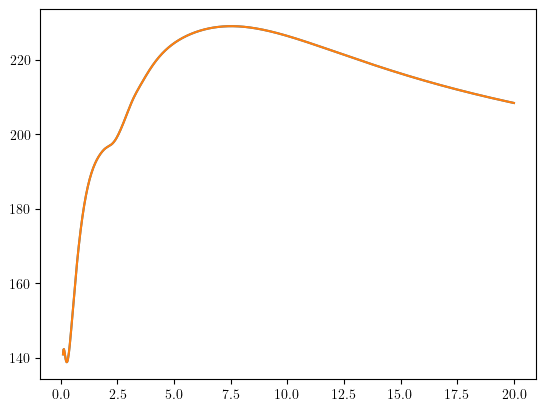

In [5]:
'''Make slowing barred potential'''

from scipy.optimize import fsolve

# First construct axisymmetric potential from baryonic Hunter24 potential + custom NFW
pot_axi_baryon = agama.Potential(file=agama_pot_path+pot_axi_baryon_path)

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    a_NFW = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer))[0]
    rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

    return rho_0, a_NFW

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, M20, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # Calculate model NFW parameters
    Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
    M20_baryon = pot_axi_baryon.enclosedMass(20)
    M20_dark = M20*1e11 - M20_baryon
    
    rho_0, a_NFW = calc_NFW_params(Menc_sun_dark, M20_dark)

    # Make DM potential
    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    # And total potential
    pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

    return pot_mod




# Then make full time-dependent potential with growing and slowing bar
def make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present):
    
    S = Omega_b_present/Omega_b
    A = bar_frac * S

    # Load full, scaled, rotated baryonic potential
    pot_bar_baryon_scaled = agama.Potential(file=agama_pot_path+pot_bar_baryon_path, scale=np.array([bartime, A, S]).T, rotation=np.array([bartime, phi_b]).T)
    # And the axisymmetrised, scaled baryonic potential with equal but negative mass
    pot_axi_baryon_neg_scaled = agama.Potential(file=agama_pot_path+pot_axi_baryon_path, scale=np.array([bartime, -A, S]).T)

    # The sum gives the scaled, rotated non-axisymmetric baryonic components (i.e. the bar)
    # Add these along with the axisymmetric potential (including DM) to get the time-dependent barred potential
    pot = agama.Potential(pot_axi, pot_bar_baryon_scaled, pot_axi_baryon_neg_scaled)

    return pot

# Make custom potential
#pot_axi = make_pot(vcirc_sun, M20, pot_axi_baryon)

# Or use Hunter+24 potential
pot_axi = pot_axi_Hunter

# Select pattern speed at which to match Hunter bar length
Omega_b_present = calc_Omega_b(8*0.9, Omega_b_1, eta, t0, t1, t2, tf)

print(Omega_b_present)

pot = make_potential(bartime, Omega_b, phi_b, bar_frac, pot_axi, Omega_b_present)


# Plot rotation curve of axisymmetric potential
R_grid = np.linspace(0.1, 20, 1001)
vcirc_grid = (-R_grid * pot_axi.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

plt.plot(R_grid, vcirc_grid)

vcirc_grid = (-R_grid * pot_axi_Hunter.force(np.array([R_grid, 0*R_grid, 0*R_grid]).T)[:,0])**0.5

plt.plot(R_grid, vcirc_grid)



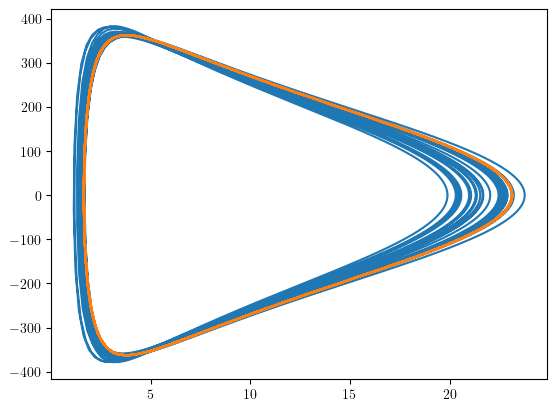

In [6]:
'''Test with individual orbits'''

ic = [8.2, 0, 0, 300, 100, 0]

traj = agama.orbit(ic=ic, potential=pot, time=tf, trajsize=10001)[1]

R_sim = np.linalg.norm(traj[:,0:2], axis=-1)
phi_sim = (np.arctan2(traj[:,1], traj[:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = traj[:,0:3] * [1, 1, 0] / R_sim[:,None]
vR_sim = (traj[:,3:6] * R_hat).sum(axis=-1)

plt.plot(R_sim, vR_sim)


traj = agama.orbit(ic=ic, potential=pot_axi, time=tf, trajsize=10001)[1]

R_sim = np.linalg.norm(traj[:,0:2], axis=-1)
phi_sim = (np.arctan2(traj[:,1], traj[:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = traj[:,0:3] * [1, 1, 0] / R_sim[:,None]
vR_sim = (traj[:,3:6] * R_hat).sum(axis=-1)

plt.plot(R_sim, vR_sim)


4.338087143765369


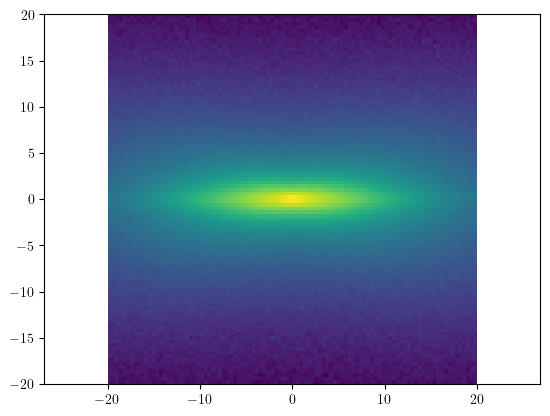

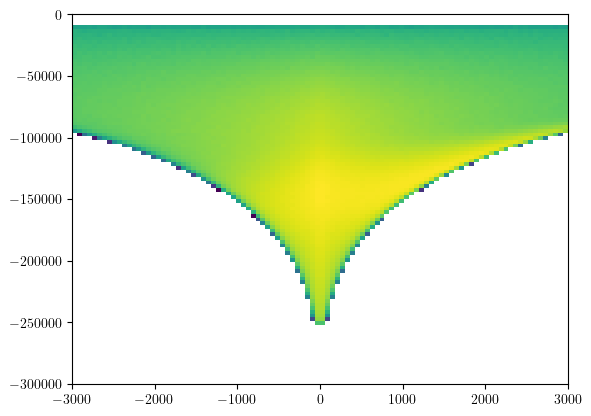

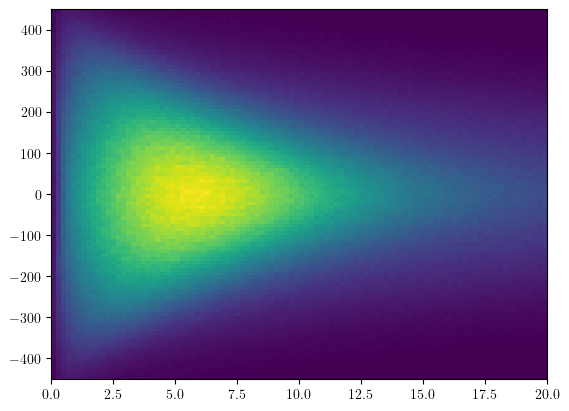

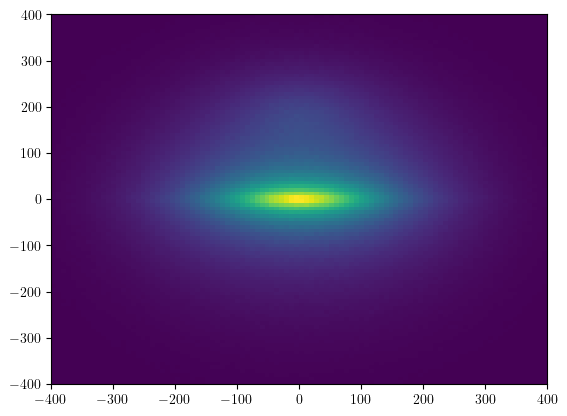

18852186


In [20]:
'''Initial distribution function'''

Gamma = 1
Beta = 4

# Create density profile from which to construct df
#density = agama.Density(type='spheroid', mass=1e9, alpha=1, beta=beta, gamma=gamma, scaleRadius=25)
#df_halo = agama.DistributionFunction(type='quasispherical', density=density, potential=pot_axi)

df_halo = agama.DistributionFunction(type='DoublePowerLaw', norm=1e9, J0=500, slopeIn=Gamma, slopeOut=Beta, coefJrIn=0.2, coefJrOut=0.2, coefJzIn=2.5, coefJzOut=2.5)#, Jcutoff=1000)

#df_disc_0 = agama.DistributionFunction(type='exponential', mass=1e9, Jphi0=500, Jz0=200, Jr0=5000)

df_disc = agama.DistributionFunction(type='exponential', mass=1e9, Jphi0=500, Jz0=200, Jr0=800)

#df_disc = agama.DistributionFunction(type='QuasiIsothermal', potential=pot_axi, mass=1e9, Rdisk=3.66, sigmar0=26.3, sigmaz0=34, Rsigmar=2*3.66, Rsigmaz=2*3.66)

df = agama.DistributionFunction(df_halo, df_disc)#, df_halo)

Nbody = int(2e7)

ic, mass = agama.GalaxyModel(pot_axi, df).sample(Nbody)

print(mass.sum()/1e9)

R = np.linalg.norm(ic[:,0:2], axis=1)
phi = np.arctan2(ic[:,1], ic[:,0])

R_hat = ic[:,0:3] * [1, 1, 0] / R[:,None]
phi_hat = np.cross([0,0,1], R_hat)
vR = (ic[:,3:6] * R_hat).sum(axis=1)
vphi = (ic[:,3:6] * phi_hat).sum(axis=-1)

Lz = np.cross(ic[:,0:3], ic[:,3:6])[:,2]
E = 0.5 * (ic[:,3:6]**2).sum(axis=-1) + pot_axi.potential(ic[:,0:3])



cut = (E > -2.5e5)*(E < -0.1e5)#*(R > 5)*(R < 20)*(abs(ic[:,2]) < 2)
#cut = (Lz > -1000)*(Lz < 1000)#*(R > 5)*(R < 20)*(abs(ic[:,2]) < 2)

plt.hist2d(ic[:,0], ic[:,2], bins=np.linspace(-20, 20, 101), norm=mcolors.LogNorm())
plt.axis('equal')
plt.show()
plt.close()

plt.hist2d(Lz[cut], E[cut], bins=(np.linspace(-3000, 3000, 101), np.linspace(-3e5, 0, 101)), norm=mcolors.LogNorm())

plt.show()
plt.close()

R_bins = np.linspace(0, 20, 101)
vR_bins = np.linspace(-450, 450, 101)
plt.hist2d(R[cut], vR[cut], bins=(R_bins, vR_bins))
plt.show()
plt.close()


#cut = (R > 7)*(R < 9)*(abs(ic[:,2])<2)
plt.hist2d(vR[cut], vphi[cut], bins=np.linspace(-400, 400, 101))#, norm=mcolors.LogNorm())
plt.show()
plt.close()


ic = ic[cut]

print(len(ic))





In [21]:
'''Run simulation'''

o = agama.orbit(ic=ic, potential=pot, time=tf, trajsize=11)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
'''Save array'''

simpath = 'sims/'

np.save(simpath+'trajs_Hunter', o)

In [ ]:
o = np.load(simpath+'trajs.npy', allow_pickle=True)

In [22]:
'''Calculate simulation quantities'''

ts = o[:,0][0]

Omega_b = np.zeros(len(ts))
phi_b = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

print(ts)
print(Omega_b)

trajs = np.stack(o[:,1]).transpose((1,0,2))

R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
r_sim = np.linalg.norm(trajs[:,:,0:3], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b[:,None] + np.pi)%(2*np.pi) - np.pi

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
r_hat = trajs[:,:,0:3] / r_sim[:,:,None]
phi_hat = np.cross([0,0,1], R_hat)

vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)
vr_sim = (trajs[:,:,3:6] * r_hat).sum(axis=-1)
vphi_sim = (trajs[:,:,3:6] * phi_hat).sum(axis=-1)

Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

E_sim = np.zeros(Lz_sim.shape)

for i in range(E_sim.shape[0]):
    E_sim[i] = 0.5 * (trajs[i,:,3:6]**2).sum(axis=-1) + pot_axi.potential(trajs[i,:,0:3])



[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4 7.2 8. ]
[60.         60.         60.         59.14826458 53.28596762 47.24409449
 42.43281368 38.51091185 35.25264359 32.50270916 30.15075377]


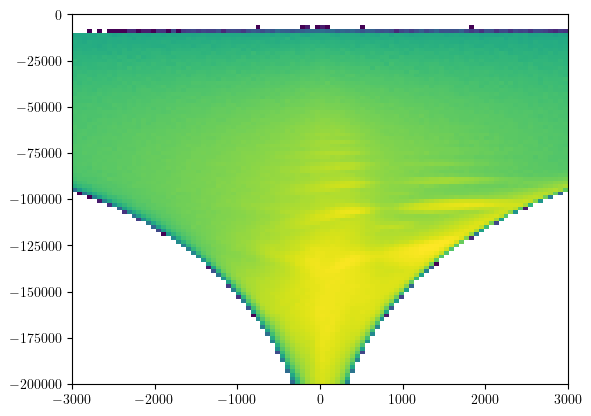

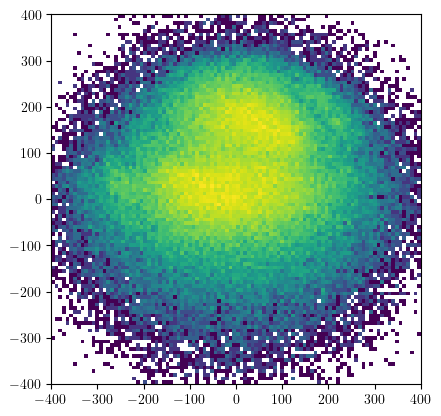

In [25]:
snap = -2

plt.hist2d(Lz_sim[snap], E_sim[snap], bins=(np.linspace(-3000, 3000, 101), np.linspace(-2e5, 0e5, 101)), norm=mcolors.LogNorm())
plt.show()
plt.close()


cut = (R_sim[snap] > 7)*(R_sim[snap] < 9)*(abs(phi_sim[snap] - 5/6*np.pi) < np.pi/12)
hist, _, _ = np.histogram2d(vR_sim[snap,cut], vphi_sim[snap,cut], bins=np.linspace(-400,400,101))
hist_antisym = (hist - np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
plt.imshow(hist.T, extent=[-400,400,-400,400], norm=mcolors.LogNorm(), origin='lower')